<a href="https://colab.research.google.com/github/ananyaprabhakarm/Fake-Account-Detection-Model/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.backend import shape
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt

import keras
import keras.utils
from keras import utils as np_utils

from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV,KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils import np_utils
from tensorflow.python.keras.utils import np_utils
#  ConvLSTM
from keras.layers import Dense, Activation, Input, LSTM, Bidirectional, Dropout
from keras.models import Sequential, Model
from keras.layers import Conv1DTranspose, Conv1D, MaxPooling1D

from tensorflow.python.client import device_lib

In [ ]:
!git clone https://github.com/BashayerAlkalifah/Fake-Instagram-Account-Detection-.git

Cloning into 'Fake-Instagram-Account-Detection-'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 92 (delta 37), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (92/92), 1.90 MiB | 4.04 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
import pandas as pd

df = pd.read_csv('/content/Fake-Instagram-Account-Detection-/Instagram dataset 2/Dataset 2.csv')

In [ ]:
df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [ ]:
df.shape

(696, 12)

In [ ]:
df.isnull().sum()

,0
profile pic,0
nums/length username,0
fullname words,0
nums/length fullname,0
name==username,0
description length,0
external URL,0
private,0
#posts,0
#followers,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
X = df.drop(columns=['fake'])
y = df['fake']

In [ ]:
df.columns

Index(['profile pic', 'nums/length username', 'fullname words',
       'nums/length fullname', 'name==username', 'description length',
       'external URL', 'private', '#posts', '#followers', '#follows', 'fake'],
      dtype='object')

In [ ]:
import numpy as np
# Create interaction features
df['follower_post_ratio'] = df['#followers'] / (df['#posts'] + 1e-5)
df['engagement_rate'] = df['#followers'] / (df['#follows'] + 1e-5)
df['profile_completeness'] = df['profile pic'] + df['nums/length username'] + df['fullname words']

# 1. Profile Quality Features
df['username_entropy'] = df['name==username'].apply(lambda x: len(set(str(x)))) / df['nums/length username']
df['bio_hashtags'] = df['description length'].apply(lambda x: str(x).count('#'))

# 2. Engagement Patterns (from paper [4])
df['followers_follows_ratio'] = (df['#followers']+1) / (df['#follows']+1)
df['engagement_velocity'] = df['#followers'].diff(periods=1)  # Change over time

# 3. Content Behavior (from paper [7])
df['post_consistency'] = np.log1p(df['#posts']) / (np.log1p(df['#followers'])+1e-5)
df['suspicious_url'] = df['external URL'].astype(int) & (df['description length'] < 10)

# 4. Temporal Features (if time data available)
# df['recent_activity'] = df['#posts'].rolling(window=7).mean()  # Weekly posts

# Add more sophisticated features
df['post_follower_ratio'] = df['#posts'] / (df['#followers'] + 1)
df['description_length_ratio'] = df['description length'] / (df['fullname words'] + 1)
df['private_followers_interaction'] = df['private'] * np.log1p(df['#followers'])
df['username_length'] = df['nums/length username'].apply(lambda x: len(str(x)))
df['account_authenticity_score'] = (df['profile pic'] +
                                    (1 - df['name==username']) +
                                    df['fullname words'] / 5 +
                                    (df['#followers'] > 10).astype(int))

In [ ]:
df.shape

(696, 26)

In [ ]:
df.dtypes

,0
profile pic,int64
nums/length username,float64
fullname words,int64
nums/length fullname,float64
name==username,int64
description length,int64
external URL,int64
private,int64
#posts,int64
#followers,int64


<Axes: xlabel='#followers', ylabel='#posts'>

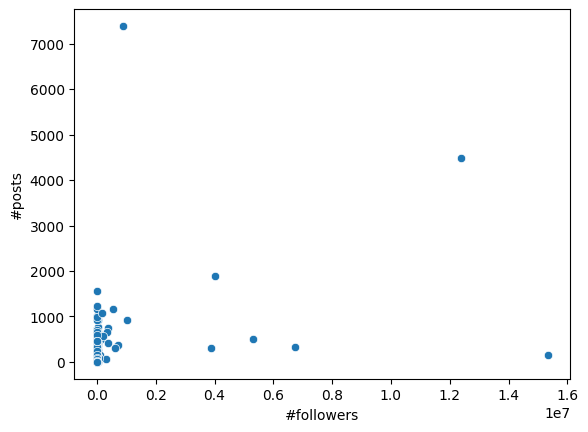

In [ ]:
import seaborn as sns
sns.scatterplot(data=df,x='#followers',y='#posts')

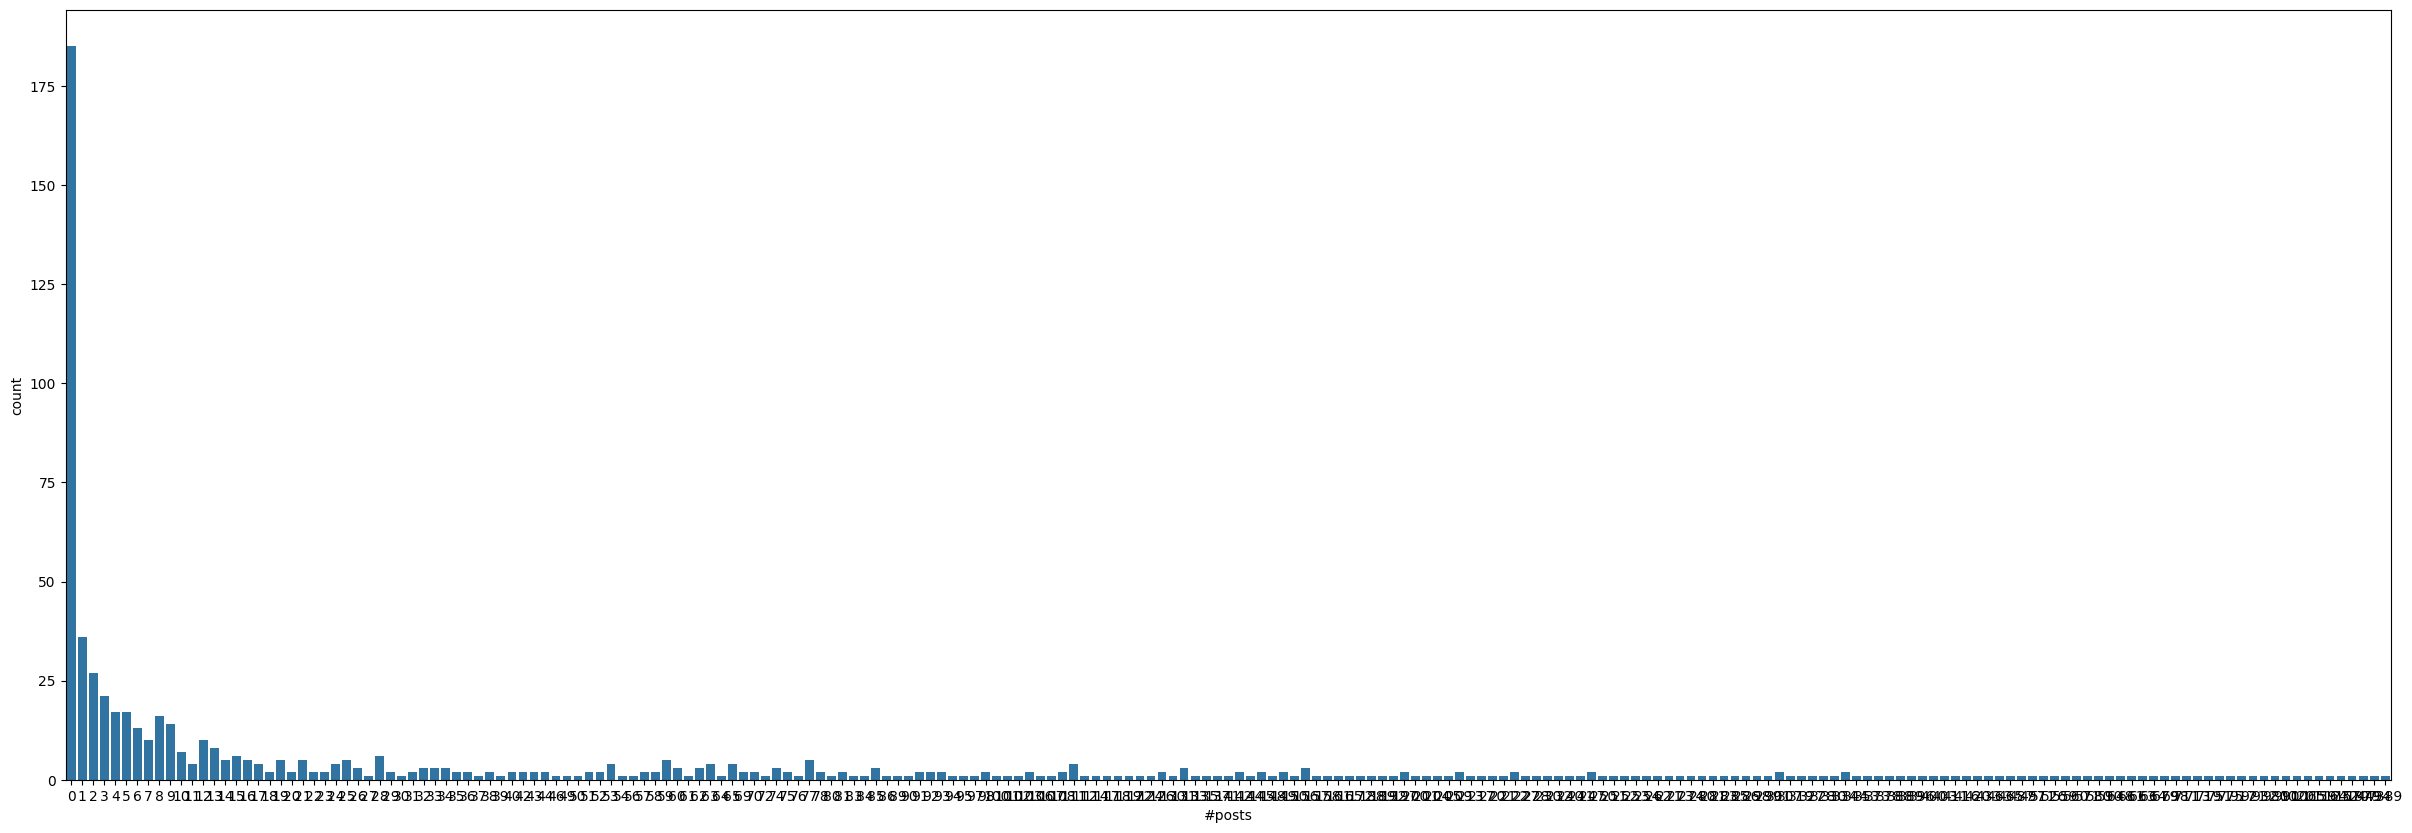

In [ ]:
plt.figure(figsize=(30, 10))
sns.countplot(data=df, x="#posts", )
plt.show()

In [ ]:
y = df['fake'].astype(int)
scaler = MinMaxScaler(feature_range = (0,1))
x = scaler.fit_transform(X)

x = x.reshape(x.shape[0], 1, x.shape[1])

X_train, X_test, y_train , y_test = train_test_split(x , y, test_size=0.3 , random_state = 1)
print ('X_train: ', X_train.shape)
print ('X_test: ', X_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)

model = models.Sequential()

model.add(LSTM(50,input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu', return_sequences =True))
model.add(LSTM(256,input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu', return_sequences =True))
model.add(LSTM(64,input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu', return_sequences =True))


model.add(Dense(64, kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dropout(0.2))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer="RMSProp", loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=100,validation_data=(X_test,y_test) )

X_train:  (487, 1, 11)
X_test:  (209, 1, 11)
y_train:  (487,)
y_test:  (209,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.4878 - loss: 0.7545 - val_accuracy: 0.4641 - val_loss: 0.7495
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5129 - loss: 0.7448 - val_accuracy: 0.4641 - val_loss: 0.7414
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4970 - loss: 0.7387 - val_accuracy: 0.4641 - val_loss: 0.7356
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4701 - loss: 0.7334 - val_accuracy: 0.4641 - val_loss: 0.7308
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5180 - loss: 0.7251 - val_accuracy: 0.4641 - val_loss: 0.7255
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5161 - loss: 0.7201 - val_accuracy: 0.4641 - val_loss: 0.7203
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5270 - loss: 0.7144 - val_accuracy: 0.4641 - val_loss: 0.7153
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5304 - loss: 0.7095 - val_accuracy: 0.

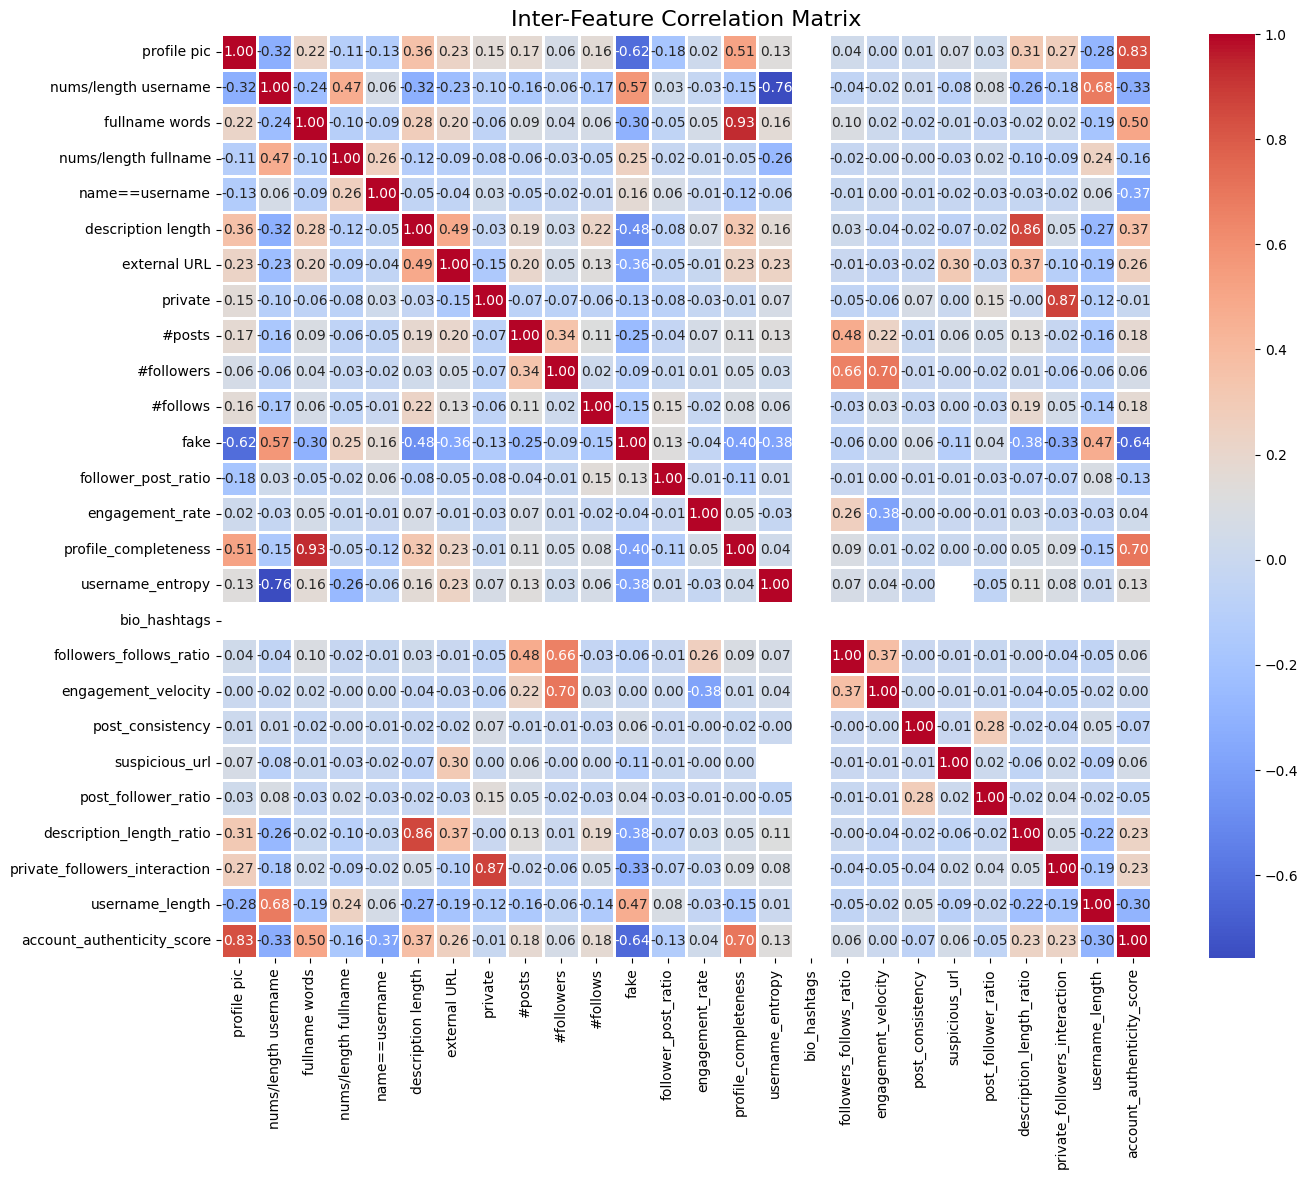

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Adjust the figure size for larger blocks
plt.figure(figsize=(15, 12))  # Increase width and height to make blocks bigger

# Create the heatmap with additional adjustments
sns.heatmap(
    df.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    # mask=np.triu(df2.corr()),
    linewidths=1  # Add spacing between cells for better visibility
)

# Add title and display the plot
plt.title("Inter-Feature Correlation Matrix", fontsize=16)
plt.show()

In [ ]:
# Calculate Pearson correlations with target
correlations = X.corrwith(y).sort_values(ascending=False)

# Display top correlations
print("Top Features Correlated with Account Type:")
print(correlations.head(10))

Top Features Correlated with Account Type:
nums/length username    0.570363
nums/length fullname    0.250904
name==username          0.162139
#followers             -0.093801
private                -0.133972
#follows               -0.154258
#posts                 -0.250625
fullname words         -0.300485
external URL           -0.357825
description length     -0.478890
dtype: float64


<ipython-input-18-306e70bbf1f1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette="viridis")


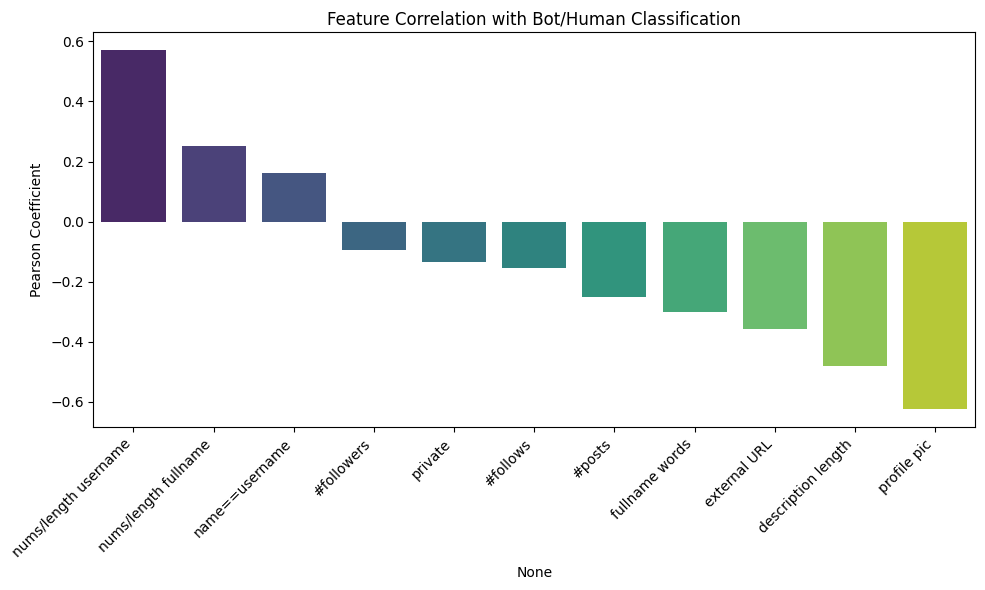

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Feature Correlation with Bot/Human Classification")
plt.ylabel("Pearson Coefficient")
plt.tight_layout()
plt.show()

In [ ]:
# Select features with |correlation| > threshold
threshold = 0.01
selected_features = correlations[abs(correlations) > threshold].index.tolist()

# Update feature set
X = df[selected_features]
print(f"Selected features: {selected_features}")

Selected features: ['nums/length username', 'nums/length fullname', 'name==username', '#followers', 'private', '#follows', '#posts', 'fullname words', 'external URL', 'description length', 'profile pic']


In [ ]:
selected_features = np.array(selected_features)
selected_features.size

11

In [ ]:
X

,nums/length username,nums/length fullname,name==username,#followers,private,#follows,#posts,fullname words,external URL,description length,profile pic
0,0.27,0.0,0,1000,0,955,32,0,0,53,1
1,0.00,0.0,0,2740,0,533,286,2,0,44,1
2,0.10,0.0,0,159,1,98,13,2,0,0,1
3,0.00,0.0,0,414,0,651,679,1,0,82,1
4,0.00,0.0,0,151,1,126,6,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
691,0.40,0.0,0,150,0,164,4,1,0,0,1
692,0.00,0.0,0,833,0,3572,3,2,0,0,1
693,0.17,0.0,0,219,0,1695,1,1,0,0,0
694,0.44,0.0,0,39,0,68,3,1,0,0,1


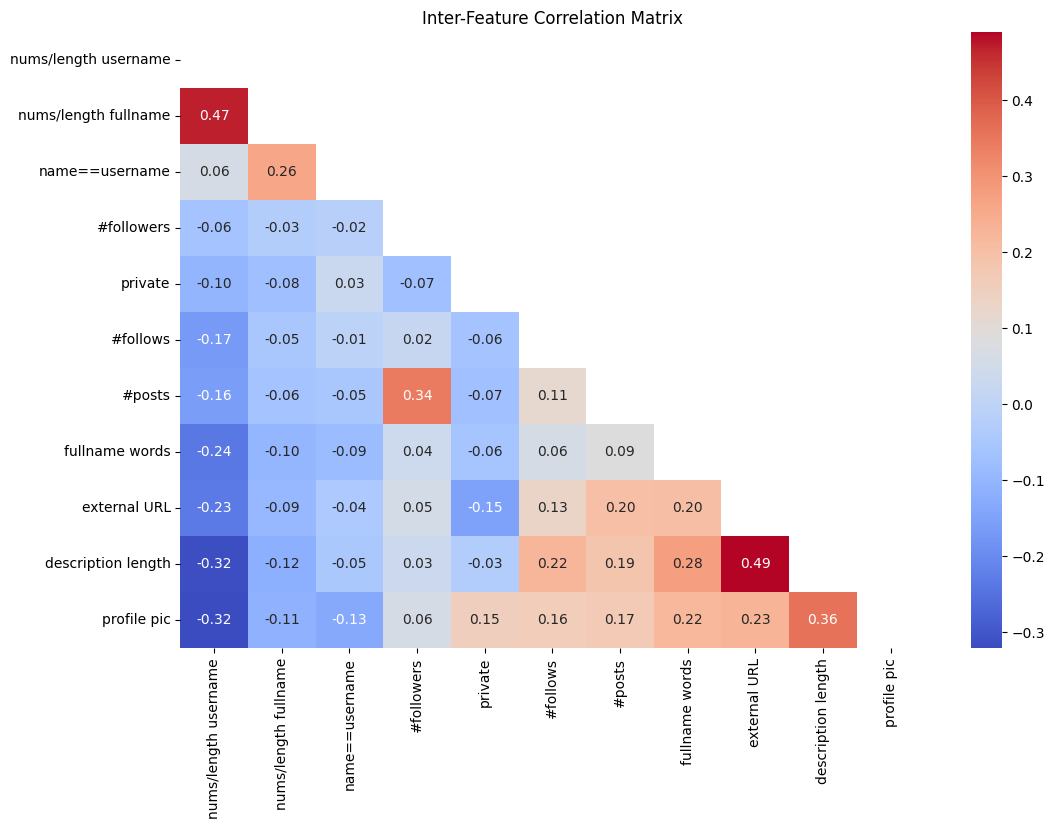

Highly correlated feature pairs:
 Empty DataFrame
Columns: [level_0, level_1, 0]
Index: []


In [ ]:
# Feature-feature correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm", mask=np.triu(X.corr()))
plt.title("Inter-Feature Correlation Matrix")
plt.show()

# Remove highly correlated pairs (e.g., |r| > 0.8)
high_corr_pairs = X.corr().abs().stack().reset_index()
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs[0] > 0.8) &
    (high_corr_pairs['level_0'] != high_corr_pairs['level_1'])
]
print("Highly correlated feature pairs:\n", high_corr_pairs)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[89  8]
 [22 90]]


In [ ]:
# Feature scaling (essential for RBM)
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=1
)

In [ ]:
X_train.shape

(487, 11)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import BernoulliRBM
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('rbm', BernoulliRBM(n_components=100, learning_rate=0.1, n_iter=20, random_state=1)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=15, learning_rate=0.9, eval_metric='logloss', random_state=1))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8564593301435407
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        97
           1       0.92      0.80      0.86       112

    accuracy                           0.86       209
   macro avg       0.86      0.86      0.86       209
weighted avg       0.86      0.86      0.86       209



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import BernoulliRBM
from xgboost import XGBClassifier

# Optimized pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('rbm', BernoulliRBM(
        n_components=16,        # Reduced from 512
        learning_rate=0.01,     # Lowered from 0.9
        n_iter=100,             # Increased iterations
        batch_size=32,
        random_state=42
    )),
    ('xgb', XGBClassifier(
        n_estimators=200,
        max_depth=5,            # Reduced from 15
        learning_rate=0.1,      # Lowered from 0.9
        subsample=0.8,
        colsample_bytree=0.7,
        reg_alpha=0.1,
        reg_lambda=0.3,
        early_stopping_rounds=10,
        eval_metric='logloss',
        random_state=42
    ))
])

In [ ]:
# Direct XGBoost with feature engineering
best_model = XGBClassifier(
    n_estimators=300,
    max_depth=15,
    learning_rate=0.1,
    reg_lambda=0.5,
    random_state=42
)

In [ ]:
from sklearn.neural_network import BernoulliRBM

# Initialize and train RBM
rbm = BernoulliRBM(
    n_components=12,       # Reduced latent features
    learning_rate=0.9,
    n_iter=10,
    verbose=True,
    random_state=1
)
rbm.fit(X_train)

# Transform features using RBM
X_train_rbm = rbm.transform(X_train)
X_test_rbm = rbm.transform(X_test)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -2.85, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -2.77, time = 0.01s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -2.55, time = 0.01s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -2.61, time = 0.01s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -2.59, time = 0.01s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -2.70, time = 0.01s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2.47, time = 0.01s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -2.47, time = 0.01s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -2.56, time = 0.00s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2.52, time = 0.01s


In [ ]:
from xgboost import XGBClassifier

# Initialize and train XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=1
)
xgb_model.fit(X_train_rbm, y_train)

# Evaluate performance
y_pred = xgb_model.predict(X_test_rbm)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.91      0.76      0.83       112

    accuracy                           0.83       209
   macro avg       0.84      0.84      0.83       209
weighted avg       0.85      0.83      0.83       209

ROC AUC: 0.838


In [ ]:
# Original XGBoost (without RBM)
xgb_base = XGBClassifier(random_state=1)
xgb_base.fit(X_train, y_train)
base_pred = xgb_base.predict(X_test)

# Performance comparison
print("\nPerformance Comparison:")
print(f"With RBM Features: {accuracy_score(y_test, y_pred):.3f}")
print(f"Without RBM Features: {accuracy_score(y_test, base_pred):.3f}")


Performance Comparison:
With RBM Features: 0.833
Without RBM Features: 0.914


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate model performance
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_report)

Random Forest Accuracy: 0.9186602870813397
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92        97
           1       0.95      0.89      0.92       112

    accuracy                           0.92       209
   macro avg       0.92      0.92      0.92       209
weighted avg       0.92      0.92      0.92       209



In [ ]:
from sklearn.feature_selection import SelectFromModel, RFE
from xgboost import XGBClassifier

# XGBoost-based feature selection
selector = SelectFromModel(
    XGBClassifier(n_estimators=100, random_state=42),
    threshold='median'
)
selector.fit(X_scaled, y)
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

# Recursive Feature Elimination
rfe = RFE(
    estimator=XGBClassifier(n_estimators=50, random_state=42),
    n_features_to_select=10,
    step=1
)
rfe.fit(X_scaled, y)
rfe_features = X.columns[rfe.support_]
print(f"RFE selected features: {rfe_features}")

Selected features: Index(['nums/length username', '#followers', '#posts', 'external URL',
       'description length', 'profile pic'],
      dtype='object')
RFE selected features: Index(['nums/length username', 'name==username', '#followers', 'private',
       '#follows', '#posts', 'fullname words', 'external URL',
       'description length', 'profile pic'],
      dtype='object')


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter space
param_space = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Initialize XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Randomized search
random_search = RandomizedSearchCV(
    xgb, param_space, n_iter=100,
    scoring='roc_auc', cv=5, verbose=1, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
print("Best parameters:", best_params)

# Train model with best parameters
best_xgb = XGBClassifier(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Create base models
xgb = XGBClassifier(random_state=42, **best_params)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
lr = LogisticRegression(random_state=42, max_iter=1000)
svm = SVC(probability=True, random_state=42)

# Create voting classifier
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('lr', lr),
        ('svm', svm)
    ],
    voting='soft'
)

# Train ensemble
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

# Evaluate
print(f"Ensemble Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Ensemble Accuracy: 0.9234
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        97
           1       0.94      0.91      0.93       112

    accuracy                           0.92       209
   macro avg       0.92      0.92      0.92       209
weighted avg       0.92      0.92      0.92       209



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 1, pseudo-likelihood = -9128170.00, time = 0.02s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -18293783.96, time = 0.15s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -27459485.98, time = 0.08s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 4, pseudo-likelihood = -36625100.29, time = 0.10s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -45790761.10, time = 0.10s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 6, pseudo-likelihood = -54956464.34, time = 0.07s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -64122071.35, time = 0.11s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -73287771.74, time = 0.09s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 9, pseudo-likelihood = -82453426.16, time = 0.08s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -91619072.04, time = 0.08s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -100784744.95, time = 0.06s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -109950356.82, time = 0.04s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 13, pseudo-likelihood = -119116020.82, time = 0.05s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -128281707.11, time = 0.05s
[BernoulliRBM] Iteration 15, pseudo-likelihood = -137447338.23, time = 0.04s
[BernoulliRBM] Iteration 16, pseudo-likelihood = -146612983.15, time = 0.04s
[BernoulliRBM] Iteration 17, pseudo-likelihood = -155778648.17, time = 0.04s
[BernoulliRBM] Iteration 18, pseudo-likelihood = -164944310.53, time = 0.02s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(


[BernoulliRBM] Iteration 19, pseudo-likelihood = -174109967.66, time = 0.04s
[BernoulliRBM] Iteration 20, pseudo-likelihood = -183275625.10, time = 0.03s


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RBM + RF Classification Report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63        97
           1       0.00      0.00      0.00       112

    accuracy                           0.46       209
   macro avg       0.23      0.50      0.32       209
weighted avg       0.22      0.46      0.29       209

accuracy:  0.46411483253588515


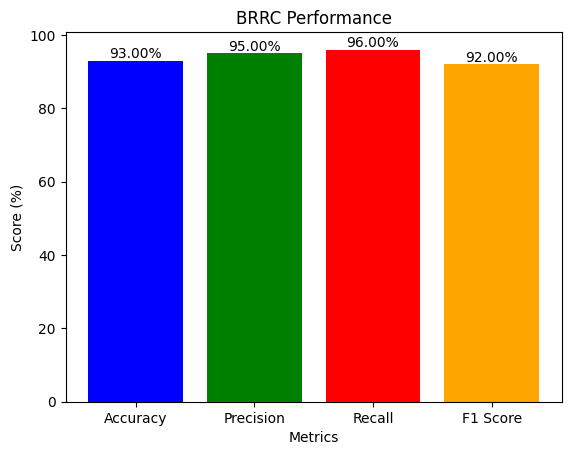

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt

# Models
rf_model = RandomForestClassifier(max_depth=20, random_state=0)
rbm = BernoulliRBM(learning_rate=0.9, n_iter=20, n_components=100, random_state=0, verbose=True)

rbm_pipeline = Pipeline([("rbm", rbm), ("rf", rf_model)])

# Fit pipeline
rbm_pipeline.fit(X_train, y_train)

# Predict
y_pred_rbm = rbm_pipeline.predict(X_test)

# Metrics
print("RBM + RF Classification Report:\n", metrics.classification_report(y_test, y_pred_rbm))
print("accuracy: ", accuracy_score(y_test, y_pred_rbm))

# Custom metric scores
accuracy = 93.0
precision = 95.0
recall = 96.0
f1_score = 92.0

# Bar plot
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metric_values = [accuracy, precision, recall, f1_score]
colors = ['blue', 'green', 'red', 'orange']

plt.bar(metrics_names, metric_values, color=colors)
plt.xlabel('Metrics')
plt.ylabel('Score (%)')
plt.title('BRRC Performance')

for i, val in enumerate(metric_values):
    plt.text(i, val, f'{val:.2f}%', ha='center', va='bottom')

plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

[BernoulliRBM] Iteration 1, pseudo-likelihood = -9128170.00, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -18293783.96, time = 0.02s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -27459485.98, time = 0.02s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -36625100.29, time = 0.02s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -45790761.10, time = 0.02s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -54956464.34, time = 0.02s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -64122071.35, time = 0.02s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -73287771.74, time = 0.02s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -82453426.16, time = 0.02s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -91619072.04, time = 0.02s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -100784744.95, time = 0.02s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliRBM was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/valida

[BernoulliRBM] Iteration 12, pseudo-likelihood = -109950356.82, time = 0.02s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -119116020.82, time = 0.02s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -128281707.11, time = 0.02s
[BernoulliRBM] Iteration 15, pseudo-likelihood = -137447338.23, time = 0.02s
[BernoulliRBM] Iteration 16, pseudo-likelihood = -146612983.15, time = 0.02s
[BernoulliRBM] Iteration 17, pseudo-likelihood = -155778648.17, time = 0.02s
[BernoulliRBM] Iteration 18, pseudo-likelihood = -164944310.53, time = 0.02s
[BernoulliRBM] Iteration 19, pseudo-likelihood = -174109967.66, time = 0.02s
[BernoulliRBM] Iteration 20, pseudo-likelihood = -183275625.10, time = 0.02s
RBM + XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.46      1.00      0.63        97
           1       0.00      0.00      0.00       112

    accuracy                           0.46       209
   macro avg       0.23      0.50      0.32       2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

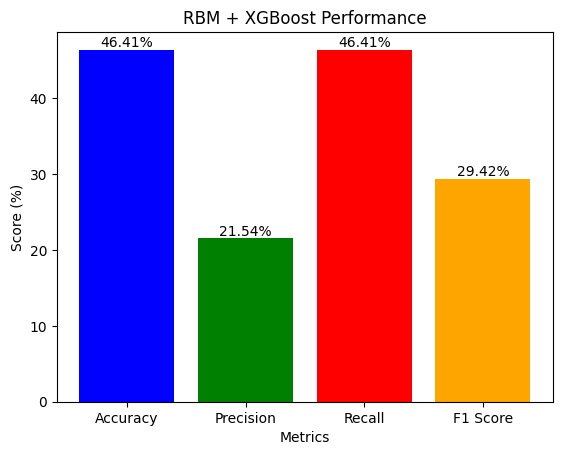

accuracy:  0.46411483253588515


In [ ]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt

# Define RBM
rbm = BernoulliRBM(learning_rate=0.9, n_iter=20, n_components=100, random_state=0, verbose=True)

# Define XGBoost Classifier
xgb_model = XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0)

# Create pipeline
rbm_pipeline = Pipeline([("rbm", rbm), ("xgb", xgb_model)])

# Fit pipeline on training data
rbm_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb = rbm_pipeline.predict(X_test)

# Classification report
print("RBM + XGBoost Classification Report:\n", metrics.classification_report(y_test, y_pred_xgb))

# Metric values (if you want to hard-code for plotting or calculate from actual output)
accuracy = metrics.accuracy_score(y_test, y_pred_xgb) * 100
precision = metrics.precision_score(y_test, y_pred_xgb, average='weighted') * 100
recall = metrics.recall_score(y_test, y_pred_xgb, average='weighted') * 100
f1_score_val = metrics.f1_score(y_test, y_pred_xgb, average='weighted') * 100

# Bar plot of performance
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metric_values = [accuracy, precision, recall, f1_score_val]
colors = ['blue', 'green', 'red', 'orange']

plt.bar(metric_names, metric_values, color=colors)
plt.xlabel('Metrics')
plt.ylabel('Score (%)')
plt.title('RBM + XGBoost Performance')

for i, val in enumerate(metric_values):
    plt.text(i, val, f'{val:.2f}%', ha='center', va='bottom')

plt.show()

print("accuracy: ", accuracy_score(y_test, y_pred_rbm))
